In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
from google.colab import files
uploaded = files.upload()

# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())


Saving TrainingData.csv to TrainingData.csv
Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%   

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['Root10DaysSeedling', 'Shoot10DaysSeedling', 'Root35DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot35DaysSeedling', 
                 'Root14DaysSeedling', 'Root24DaysSeedling', 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot21DaysSeedling', 'PCC', 'Shoot14DaysSeedling', 'Root52DaysSeedling', 'Shoot17DaysSeedling', 
                 'Leaf21DaysSeedling', 'log_2FoldChange', 'ET', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        Root10DaysSeedling  Shoot10DaysSeedling  Root35DaysSeedling  \
count        41110.000000         41110.000000        41110.000000   
mean            -0.522040            -0.545055           -0.596196   
std              0.498568             0.477438            0.461679   
min             -1.000000            -1.000000           -1.000000   
25%             -0.901371            -0.906055           -0.937286   
50%             -0.663664            -0.698864           -0.769184   
75%             -0.378497            -0.250588           -0.323664   
max              1.000000             1.000000            1.000000   

       Leaf45DaysOldPlant  Shoot35DaysSeedling  Root14DaysSeedling  \
count        41110.000000         41110.000000        41110.000000   
mean            -0.585144            -0.558906           -0.646982   
std              0.399046             0.506423            0.393549   
min             -1.000000  

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Class=112, n=66 (0.161%)
Class=113, n=66 (0.161%)
Class=114, n=65 (0.158%)
Class=115, n=64 (0.156%)
Class=116, n=63 (0.153%)
Class=117, n=63 (0.153%)
Class=118, n=62 (0.151%)
Class=119, n=61 (0.148%)
Class=120, n=60 (0.146%)
Class=121, n=60 (0.146%)
Class=122, n=60 (0.146%)
Class=123, n=60 (0.146%)
Class=124, n=60 (0.146%)
Class=125, n=60 (0.146%)
Class=126, n=60 (0.146%)
Class=127, n=60 (0.146%)
Class=128, n=60 (0.146%)
Class=129, n=60 (0.146%)
Class=130, n=59 (0.144%)
Class=131, n=59 (0.144%)
Class=132, n=58 (0.141%)
Class=133, n=56 (0.136%)
Class=134, n=56 (0.136%)
Class=135, n=56 (0.136%)
Class=136, n=56 (0.136%)
Class=137, n=56 (0.136%)
Class=138, n=56 (0.136%)
Class=139, n=56 (0.136%)
Class=140, n=56 (0.136%)
Class=141, n=56 (0.136%)
Class=142, n=55 (0.134%)
Class=143, n=55 (0.134%)
Class=144, n=54 (0.131%)
Class=145, n=54 (0.131%)
Class=146, n=54 (0.131%)
Class=147, n=54 (0.131%)
Class=148, n=54 (0.131%)
Class=149, n=53 (0.129%)
Class=150, n=52 (0.126%)
Class=151, n=52 (0.126%)

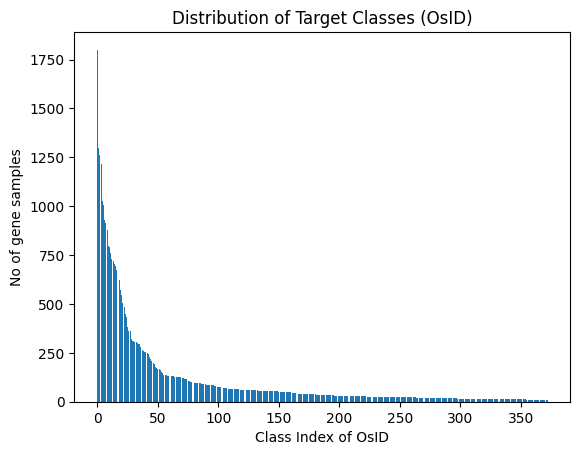

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=100, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 5.0024 - accuracy: 0.0395 - val_loss: 4.9110 - val_accuracy: 0.0315
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 4.5618 - accuracy: 0.0869 - val_loss: 4.3817 - val_accuracy: 0.1021
Epoch 3/100
1846/1846 [==============================] - 6s 3ms/step - loss: 4.0885 - accuracy: 0.1259 - val_loss: 4.0548 - val_accuracy: 0.1256
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7606 - accuracy: 0.1715 - val_loss: 3.7764 - val_accuracy: 0.1903
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5013 - accuracy: 0.2161 - val_loss: 3.5583 - val_accuracy: 0.2222
Epoch 6/100
1846/1846 [==============================] - 11s 6ms/step - loss: 3.2942 - accuracy: 0.2432 - val_loss: 3.4059 - val_accuracy: 0.2466
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1284 - accurac

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 5.0082 - accuracy: 0.0388 - val_loss: 4.8967 - val_accuracy: 0.0768
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.4170 - accuracy: 0.1021 - val_loss: 4.3126 - val_accuracy: 0.1254
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.9611 - accuracy: 0.1291 - val_loss: 3.9944 - val_accuracy: 0.1518
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.6685 - accuracy: 0.1700 - val_loss: 3.8062 - val_accuracy: 0.1373
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4279 - accuracy: 0.2009 - val_loss: 3.5575 - val_accuracy: 0.2299
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 3.2172 - accuracy: 0.2522 - val_loss: 3.4772 - val_accuracy: 0.2194
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0368 - accuracy: 0.2734 - val_loss: 3.3227 - val_accuracy: 0.23

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 9s 4ms/step - loss: 5.0097 - accuracy: 0.0453 - val_loss: 4.7150 - val_accuracy: 0.0750
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.2767 - accuracy: 0.1104 - val_loss: 4.1237 - val_accuracy: 0.1439
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.8057 - accuracy: 0.1898 - val_loss: 3.7115 - val_accuracy: 0.2851
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.2132 - accuracy: 0.3067 - val_loss: 3.0831 - val_accuracy: 0.3551
Epoch 5/100
1846/1846 [==============================] - 6s 3ms/step - loss: 2.6245 - accuracy: 0.4008 - val_loss: 2.6547 - val_accuracy: 0.4101
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.2205 - accuracy: 0.4601 - val_loss: 2.4079 - val_accuracy: 0.5155
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9451 - accuracy: 0.5190 - val_loss: 2.2580 - val_accuracy: 0.50

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 8s 3ms/step - loss: 4.9597 - accuracy: 0.0488 - val_loss: 4.6052 - val_accuracy: 0.1014
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 4.1609 - accuracy: 0.1436 - val_loss: 4.0329 - val_accuracy: 0.2106
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6310 - accuracy: 0.2276 - val_loss: 3.6949 - val_accuracy: 0.2233
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.2270 - accuracy: 0.2965 - val_loss: 3.3320 - val_accuracy: 0.3320
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.8640 - accuracy: 0.3545 - val_loss: 3.0609 - val_accuracy: 0.3564
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.5846 - accuracy: 0.3951 - val_loss: 2.8446 - val_accuracy: 0.3870
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.2966 - accuracy: 0.4531 - val_loss: 2.5257 - val_ac

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 10s 5ms/step - loss: 5.0268 - accuracy: 0.0380 - val_loss: 4.8983 - val_accuracy: 0.0315
Epoch 2/100
1846/1846 [==============================] - 6s 3ms/step - loss: 4.5230 - accuracy: 0.1029 - val_loss: 4.2782 - val_accuracy: 0.1551
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.6129 - accuracy: 0.2584 - val_loss: 3.3547 - val_accuracy: 0.3197
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8755 - accuracy: 0.3917 - val_loss: 2.8556 - val_accuracy: 0.4629
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.3377 - accuracy: 0.4867 - val_loss: 2.4272 - val_accuracy: 0.5127
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9488 - accuracy: 0.5609 - val_loss: 2.1577 - val_accuracy: 0.5956
Epoch 7/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.6859 - accuracy: 0.6060 - val_loss: 1.9716 - val_accuracy: 0.

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 4ms/step - loss: 4.8298 - accuracy: 0.0536 - val_loss: 4.2538 - val_accuracy: 0.1151
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5360 - accuracy: 0.2725 - val_loss: 3.2497 - val_accuracy: 0.3839
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6399 - accuracy: 0.4497 - val_loss: 2.6754 - val_accuracy: 0.4964
Epoch 4/100
1846/1846 [==============================] - 6s 3ms/step - loss: 2.0884 - accuracy: 0.5386 - val_loss: 2.3447 - val_accuracy: 0.5683
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.7619 - accuracy: 0.5891 - val_loss: 2.1957 - val_accuracy: 0.5705
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5591 - accuracy: 0.6175 - val_loss: 1.9706 - val_accuracy: 0.6251
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.4129 - accuracy: 0.6500 - val_loss: 1.8243 - val_ac

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 9s 4ms/step - loss: 4.7414 - accuracy: 0.0684 - val_loss: 4.1921 - val_accuracy: 0.0997
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.6573 - accuracy: 0.2555 - val_loss: 3.3855 - val_accuracy: 0.4088
Epoch 3/100
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8168 - accuracy: 0.4388 - val_loss: 2.6757 - val_accuracy: 0.4607
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.1647 - accuracy: 0.5388 - val_loss: 2.1698 - val_accuracy: 0.5789
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6700 - accuracy: 0.6202 - val_loss: 1.7762 - val_accuracy: 0.6385
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.3415 - accuracy: 0.6889 - val_loss: 1.6098 - val_accuracy: 0.6306
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1566 - accuracy: 0.7198 - val_loss: 1.4568 - val_accuracy: 0.71

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 9s 4ms/step - loss: 4.9733 - accuracy: 0.0530 - val_loss: 4.5714 - val_accuracy: 0.1430
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.8395 - accuracy: 0.2267 - val_loss: 3.4988 - val_accuracy: 0.2856
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.9430 - accuracy: 0.3983 - val_loss: 2.9794 - val_accuracy: 0.4574
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3857 - accuracy: 0.4805 - val_loss: 2.6734 - val_accuracy: 0.5111
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.0342 - accuracy: 0.5449 - val_loss: 2.4523 - val_accuracy: 0.6183
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8030 - accuracy: 0.5939 - val_loss: 2.2993 - val_accuracy: 0.6009
Epoch 7/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.6243 - accuracy: 0.6312 - val_loss: 2.1797 - val_accuracy: 0.6

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 11s 5ms/step - loss: 4.6951 - accuracy: 0.0803 - val_loss: 4.1277 - val_accuracy: 0.1595
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5040 - accuracy: 0.2790 - val_loss: 3.1504 - val_accuracy: 0.4046
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.6050 - accuracy: 0.4688 - val_loss: 2.5920 - val_accuracy: 0.4620
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0746 - accuracy: 0.5334 - val_loss: 2.2351 - val_accuracy: 0.5474
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.7176 - accuracy: 0.6010 - val_loss: 1.9484 - val_accuracy: 0.5613
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4508 - accuracy: 0.6474 - val_loss: 1.7304 - val_accuracy: 0.6568
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.2591 - accuracy: 0.6872 - val_loss: 1.5760 - val_accuracy: 0.6

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 9s 4ms/step - loss: 4.8892 - accuracy: 0.0527 - val_loss: 4.4303 - val_accuracy: 0.0823
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7759 - accuracy: 0.2184 - val_loss: 3.4781 - val_accuracy: 0.3182
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.9067 - accuracy: 0.4204 - val_loss: 2.9731 - val_accuracy: 0.4550
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3665 - accuracy: 0.4900 - val_loss: 2.6277 - val_accuracy: 0.5133
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9960 - accuracy: 0.5454 - val_loss: 2.3827 - val_accuracy: 0.6293
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.7305 - accuracy: 0.5943 - val_loss: 2.2323 - val_accuracy: 0.6004
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.5407 - accuracy: 0.6366 - val_loss: 2.0737 - val_accuracy: 0.65

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 8s 4ms/step - loss: 4.7430 - accuracy: 0.0654 - val_loss: 4.1834 - val_accuracy: 0.0924
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7325 - accuracy: 0.1670 - val_loss: 3.5711 - val_accuracy: 0.3153
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0553 - accuracy: 0.3950 - val_loss: 2.9442 - val_accuracy: 0.4568
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.4278 - accuracy: 0.5108 - val_loss: 2.5247 - val_accuracy: 0.5085
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9893 - accuracy: 0.5770 - val_loss: 2.1866 - val_accuracy: 0.6048
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6837 - accuracy: 0.6158 - val_loss: 1.9519 - val_accuracy: 0.5941
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4646 - accuracy: 0.6512 - val_loss: 1.7766 - val_ac

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 11s 5ms/step - loss: 4.6362 - accuracy: 0.0626 - val_loss: 4.1189 - val_accuracy: 0.1641
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6205 - accuracy: 0.2069 - val_loss: 3.4198 - val_accuracy: 0.3153
Epoch 3/100
1846/1846 [==============================] - 10s 5ms/step - loss: 2.6787 - accuracy: 0.4369 - val_loss: 2.6392 - val_accuracy: 0.5250
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9497 - accuracy: 0.5629 - val_loss: 2.2679 - val_accuracy: 0.5688
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.5657 - accuracy: 0.6278 - val_loss: 1.9546 - val_accuracy: 0.6363
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.3493 - accuracy: 0.6654 - val_loss: 1.8351 - val_accuracy: 0.6429
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.2062 - accuracy: 0.6900 - val_loss: 1.7793 - val_accuracy: 0.

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 4ms/step - loss: 4.5009 - accuracy: 0.0866 - val_loss: 3.9338 - val_accuracy: 0.1956
Epoch 2/100
1846/1846 [==============================] - 10s 5ms/step - loss: 3.3073 - accuracy: 0.3059 - val_loss: 3.1155 - val_accuracy: 0.4224
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5668 - accuracy: 0.4904 - val_loss: 2.6194 - val_accuracy: 0.5140
Epoch 4/100
1846/1846 [==============================] - 10s 5ms/step - loss: 2.0911 - accuracy: 0.5655 - val_loss: 2.2701 - val_accuracy: 0.5795
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.7456 - accuracy: 0.6230 - val_loss: 2.0012 - val_accuracy: 0.6464
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.4891 - accuracy: 0.6652 - val_loss: 1.8497 - val_accuracy: 0.6587
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.3050 - accuracy: 0.7003 - val_loss: 1.6849 - val

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.6151 - accuracy: 0.0842 - val_loss: 4.1597 - val_accuracy: 0.1083
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.6903 - accuracy: 0.1526 - val_loss: 3.5012 - val_accuracy: 0.2605
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.8574 - accuracy: 0.3883 - val_loss: 2.7772 - val_accuracy: 0.4647
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.1787 - accuracy: 0.5384 - val_loss: 2.2644 - val_accuracy: 0.5848
Epoch 5/100
1846/1846 [==============================] - 8s 5ms/step - loss: 1.7216 - accuracy: 0.6160 - val_loss: 2.0041 - val_accuracy: 0.6293
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4417 - accuracy: 0.6651 - val_loss: 1.7685 - val_accuracy: 0.6693
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.2733 - accuracy: 0.6872 - val_loss: 1.6702 - val_accuracy: 0.66

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 13s 6ms/step - loss: 4.4476 - accuracy: 0.1000 - val_loss: 4.0170 - val_accuracy: 0.1751
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5854 - accuracy: 0.2078 - val_loss: 3.3076 - val_accuracy: 0.2882
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.7082 - accuracy: 0.4334 - val_loss: 2.4949 - val_accuracy: 0.5175
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.9960 - accuracy: 0.5718 - val_loss: 1.9706 - val_accuracy: 0.6112
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.5558 - accuracy: 0.6437 - val_loss: 1.6210 - val_accuracy: 0.6669
Epoch 6/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.2693 - accuracy: 0.6877 - val_loss: 1.4169 - val_accuracy: 0.6992
Epoch 7/100
1846/1846 [==============================] - 8s 5ms/step - loss: 1.0834 - accuracy: 0.7200 - val_loss: 1.2422 - val_accuracy: 0.

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 11s 5ms/step - loss: 4.4868 - accuracy: 0.0954 - val_loss: 4.0175 - val_accuracy: 0.1826
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5110 - accuracy: 0.2248 - val_loss: 3.2680 - val_accuracy: 0.3859
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.6665 - accuracy: 0.4697 - val_loss: 2.5732 - val_accuracy: 0.5256
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.0424 - accuracy: 0.5751 - val_loss: 2.1747 - val_accuracy: 0.6189
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6529 - accuracy: 0.6442 - val_loss: 1.9543 - val_accuracy: 0.6464
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.4017 - accuracy: 0.6810 - val_loss: 1.7191 - val_accuracy: 0.6966
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2393 - accuracy: 0.6988 - val_loss: 1.6901 - val_accuracy: 0.6

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 11s 5ms/step - loss: 4.4196 - accuracy: 0.1041 - val_loss: 3.9327 - val_accuracy: 0.1487
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.4286 - accuracy: 0.2285 - val_loss: 3.1052 - val_accuracy: 0.4121
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.4801 - accuracy: 0.4860 - val_loss: 2.3118 - val_accuracy: 0.5314
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8267 - accuracy: 0.6082 - val_loss: 1.8655 - val_accuracy: 0.6279
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.4484 - accuracy: 0.6703 - val_loss: 1.6224 - val_accuracy: 0.6697
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.2003 - accuracy: 0.7090 - val_loss: 1.4413 - val_accuracy: 0.7142
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.0543 - accuracy: 0.7349 - val_loss: 1.3200 - val_a

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 5ms/step - loss: 4.5007 - accuracy: 0.0916 - val_loss: 4.0537 - val_accuracy: 0.1316
Epoch 2/100
1846/1846 [==============================] - 8s 5ms/step - loss: 3.6060 - accuracy: 0.1820 - val_loss: 3.4546 - val_accuracy: 0.2000
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.8496 - accuracy: 0.3847 - val_loss: 2.6541 - val_accuracy: 0.4981
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.0871 - accuracy: 0.5548 - val_loss: 2.1505 - val_accuracy: 0.5773
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6169 - accuracy: 0.6301 - val_loss: 1.8795 - val_accuracy: 0.6607
Epoch 6/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.3405 - accuracy: 0.6800 - val_loss: 1.6663 - val_accuracy: 0.6869
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.1723 - accuracy: 0.7106 - val_loss: 1.5445 - val_

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 11s 5ms/step - loss: 4.5224 - accuracy: 0.0801 - val_loss: 4.0477 - val_accuracy: 0.1505
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5108 - accuracy: 0.2430 - val_loss: 3.1999 - val_accuracy: 0.3333
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.6372 - accuracy: 0.4300 - val_loss: 2.6020 - val_accuracy: 0.5047
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0880 - accuracy: 0.5477 - val_loss: 2.1838 - val_accuracy: 0.5604
Epoch 5/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.7072 - accuracy: 0.6212 - val_loss: 1.9051 - val_accuracy: 0.6431
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.4571 - accuracy: 0.6666 - val_loss: 1.7479 - val_accuracy: 0.6880
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.2737 - accuracy: 0.6973 - val_loss: 1.5358 - val_

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5347 - accuracy: 0.0857 - val_loss: 4.0470 - val_accuracy: 0.1410
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.5035 - accuracy: 0.2396 - val_loss: 3.2683 - val_accuracy: 0.3124
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.6358 - accuracy: 0.4338 - val_loss: 2.6108 - val_accuracy: 0.4574
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.0060 - accuracy: 0.5663 - val_loss: 2.1713 - val_accuracy: 0.5901
Epoch 5/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6014 - accuracy: 0.6316 - val_loss: 1.8976 - val_accuracy: 0.6343
Epoch 6/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.3432 - accuracy: 0.6778 - val_loss: 1.7167 - val_accuracy: 0.6693
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.1802 - accuracy: 0.7069 - val_loss: 1.5383 - val_accuracy: 0.7

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5805 - accuracy: 0.0854 - val_loss: 4.1752 - val_accuracy: 0.1311
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.7439 - accuracy: 0.1645 - val_loss: 3.5940 - val_accuracy: 0.1947
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.1203 - accuracy: 0.3021 - val_loss: 3.0081 - val_accuracy: 0.3795
Epoch 4/100
1846/1846 [==============================] - 10s 5ms/step - loss: 2.5057 - accuracy: 0.4511 - val_loss: 2.5850 - val_accuracy: 0.5186
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.0746 - accuracy: 0.5429 - val_loss: 2.2761 - val_accuracy: 0.5595
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7656 - accuracy: 0.5993 - val_loss: 2.0479 - val_accuracy: 0.6352
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5256 - accuracy: 0.6430 - val_loss: 1.9087 - val_accuracy: 0.6

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 4ms/step - loss: 4.4627 - accuracy: 0.0838 - val_loss: 4.0664 - val_accuracy: 0.1624
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5878 - accuracy: 0.1881 - val_loss: 3.4221 - val_accuracy: 0.2000
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.9076 - accuracy: 0.3307 - val_loss: 2.7900 - val_accuracy: 0.3864
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.2453 - accuracy: 0.4861 - val_loss: 2.2769 - val_accuracy: 0.5635
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.7923 - accuracy: 0.5805 - val_loss: 2.0171 - val_accuracy: 0.5787
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.4982 - accuracy: 0.6476 - val_loss: 1.7679 - val_accuracy: 0.6678
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2966 - accuracy: 0.6932 - val_loss: 1.6562 - val_a

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 11s 5ms/step - loss: 4.8107 - accuracy: 0.0544 - val_loss: 4.3135 - val_accuracy: 0.0761
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.9256 - accuracy: 0.1318 - val_loss: 3.8108 - val_accuracy: 0.1974
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.2850 - accuracy: 0.2988 - val_loss: 3.1735 - val_accuracy: 0.4055
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6615 - accuracy: 0.4330 - val_loss: 2.7176 - val_accuracy: 0.4513
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.2128 - accuracy: 0.5062 - val_loss: 2.4069 - val_accuracy: 0.5241
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.8930 - accuracy: 0.5669 - val_loss: 2.2032 - val_accuracy: 0.5760
Epoch 7/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.6675 - accuracy: 0.6154 - val_loss: 2.0094 - val_

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 12s 5ms/step - loss: 4.6253 - accuracy: 0.0839 - val_loss: 4.1271 - val_accuracy: 0.1360
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.5954 - accuracy: 0.1997 - val_loss: 3.4683 - val_accuracy: 0.2933
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.7363 - accuracy: 0.4097 - val_loss: 2.7223 - val_accuracy: 0.4715
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.1175 - accuracy: 0.5197 - val_loss: 2.3498 - val_accuracy: 0.5461
Epoch 5/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.7277 - accuracy: 0.5929 - val_loss: 2.0595 - val_accuracy: 0.6163
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.4545 - accuracy: 0.6446 - val_loss: 1.8153 - val_accuracy: 0.6761
Epoch 7/100
1846/1846 [==============================] - 11s 6ms/step - loss: 1.2810 - accuracy: 0.6782 - val_loss: 1.7663 - val

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 5ms/step - loss: 4.8513 - accuracy: 0.0624 - val_loss: 4.3554 - val_accuracy: 0.1171
Epoch 2/100
1846/1846 [==============================] - 10s 6ms/step - loss: 3.8907 - accuracy: 0.1737 - val_loss: 3.5923 - val_accuracy: 0.2924
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.1177 - accuracy: 0.3616 - val_loss: 3.0282 - val_accuracy: 0.3989
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.5778 - accuracy: 0.4453 - val_loss: 2.6682 - val_accuracy: 0.4898
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.1882 - accuracy: 0.5068 - val_loss: 2.3803 - val_accuracy: 0.5006
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.9265 - accuracy: 0.5492 - val_loss: 2.1511 - val_accuracy: 0.5545
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.7418 - accuracy: 0.5775 - val_loss: 2.0774 - val_

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 9s 4ms/step - loss: 4.6361 - accuracy: 0.0736 - val_loss: 4.1608 - val_accuracy: 0.1267
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.7468 - accuracy: 0.1737 - val_loss: 3.5713 - val_accuracy: 0.2645
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.0572 - accuracy: 0.3477 - val_loss: 3.0465 - val_accuracy: 0.4502
Epoch 4/100
1846/1846 [==============================] - 10s 5ms/step - loss: 2.5087 - accuracy: 0.4866 - val_loss: 2.6913 - val_accuracy: 0.4981
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.1258 - accuracy: 0.5290 - val_loss: 2.4210 - val_accuracy: 0.5437
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.8352 - accuracy: 0.5787 - val_loss: 2.1392 - val_accuracy: 0.6165
Epoch 7/100
1846/1846 [==============================] - 11s 6ms/step - loss: 1.5978 - accuracy: 0.6261 - val_loss: 2.0280 - val_accuracy: 0.

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 12s 6ms/step - loss: 4.5861 - accuracy: 0.0821 - val_loss: 4.1058 - val_accuracy: 0.0950
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.6723 - accuracy: 0.1747 - val_loss: 3.5366 - val_accuracy: 0.1993
Epoch 3/100
1846/1846 [==============================] - 8s 5ms/step - loss: 3.1434 - accuracy: 0.2871 - val_loss: 3.0564 - val_accuracy: 0.3217
Epoch 4/100
1846/1846 [==============================] - 10s 5ms/step - loss: 2.5996 - accuracy: 0.4132 - val_loss: 2.5855 - val_accuracy: 0.4458
Epoch 5/100
1846/1846 [==============================] - 8s 5ms/step - loss: 2.1610 - accuracy: 0.4975 - val_loss: 2.2342 - val_accuracy: 0.5096
Epoch 6/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.8450 - accuracy: 0.5479 - val_loss: 2.0055 - val_accuracy: 0.5584
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.6037 - accuracy: 0.5970 - val_loss: 1.8067 - val

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 11s 5ms/step - loss: 4.6773 - accuracy: 0.0685 - val_loss: 4.1818 - val_accuracy: 0.1008
Epoch 2/100
1846/1846 [==============================] - 8s 5ms/step - loss: 3.7581 - accuracy: 0.1558 - val_loss: 3.6689 - val_accuracy: 0.2002
Epoch 3/100
1846/1846 [==============================] - 10s 5ms/step - loss: 3.1536 - accuracy: 0.3079 - val_loss: 3.1531 - val_accuracy: 0.3694
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.6052 - accuracy: 0.4306 - val_loss: 2.7991 - val_accuracy: 0.4728
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.1870 - accuracy: 0.5204 - val_loss: 2.5621 - val_accuracy: 0.5030
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.8782 - accuracy: 0.5744 - val_loss: 2.3359 - val_accuracy: 0.6037
Epoch 7/100
1846/1846 [==============================] - 8s 5ms/step - loss: 1.6433 - accuracy: 0.6222 - val_loss: 2.1666 - val_

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 10s 4ms/step - loss: 4.7144 - accuracy: 0.0681 - val_loss: 4.2396 - val_accuracy: 0.1025
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.8426 - accuracy: 0.1454 - val_loss: 3.6694 - val_accuracy: 0.1771
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.2123 - accuracy: 0.2992 - val_loss: 3.1072 - val_accuracy: 0.3551
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6425 - accuracy: 0.4085 - val_loss: 2.6504 - val_accuracy: 0.4352
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.2413 - accuracy: 0.4669 - val_loss: 2.3527 - val_accuracy: 0.4860
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.9609 - accuracy: 0.5154 - val_loss: 2.1614 - val_accuracy: 0.5179
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.7294 - accuracy: 0.5622 - val_loss: 1.9727 - val_accuracy: 0.5

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 5ms/step - loss: 4.5398 - accuracy: 0.0903 - val_loss: 4.0778 - val_accuracy: 0.1399
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6268 - accuracy: 0.1981 - val_loss: 3.3786 - val_accuracy: 0.3292
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.7914 - accuracy: 0.4026 - val_loss: 2.8037 - val_accuracy: 0.4832
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.2496 - accuracy: 0.5082 - val_loss: 2.4479 - val_accuracy: 0.5223
Epoch 5/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.9056 - accuracy: 0.5497 - val_loss: 2.1913 - val_accuracy: 0.5679
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6666 - accuracy: 0.5928 - val_loss: 1.9762 - val_accuracy: 0.6255
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.4794 - accuracy: 0.6326 - val_loss: 1.8227 - val_

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 5ms/step - loss: 4.6825 - accuracy: 0.0733 - val_loss: 4.2025 - val_accuracy: 0.1144
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7641 - accuracy: 0.1508 - val_loss: 3.6536 - val_accuracy: 0.1749
Epoch 3/100
1846/1846 [==============================] - 10s 5ms/step - loss: 3.2098 - accuracy: 0.2742 - val_loss: 3.1465 - val_accuracy: 0.3765
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.6898 - accuracy: 0.4294 - val_loss: 2.7022 - val_accuracy: 0.4770
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.2658 - accuracy: 0.5094 - val_loss: 2.4166 - val_accuracy: 0.5364
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9396 - accuracy: 0.5540 - val_loss: 2.1385 - val_accuracy: 0.5681
Epoch 7/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.7048 - accuracy: 0.5921 - val_loss: 1.9948 - val

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 10s 5ms/step - loss: 4.5264 - accuracy: 0.0881 - val_loss: 4.1344 - val_accuracy: 0.1278
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.7389 - accuracy: 0.1630 - val_loss: 3.6576 - val_accuracy: 0.1857
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.2597 - accuracy: 0.2323 - val_loss: 3.2448 - val_accuracy: 0.2572
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.8983 - accuracy: 0.3074 - val_loss: 2.9847 - val_accuracy: 0.3377
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.5744 - accuracy: 0.3906 - val_loss: 2.6510 - val_accuracy: 0.4363
Epoch 6/100
1846/1846 [==============================] - 10s 6ms/step - loss: 2.1856 - accuracy: 0.4938 - val_loss: 2.3643 - val_accuracy: 0.4880
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.8739 - accuracy: 0.5573 - val_loss: 2.1651 - val_accuracy: 0.

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 4ms/step - loss: 4.6812 - accuracy: 0.0726 - val_loss: 4.2833 - val_accuracy: 0.0964
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.8750 - accuracy: 0.1252 - val_loss: 3.7222 - val_accuracy: 0.1538
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.3365 - accuracy: 0.2398 - val_loss: 3.1797 - val_accuracy: 0.3127
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.7224 - accuracy: 0.3938 - val_loss: 2.7063 - val_accuracy: 0.4418
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.3023 - accuracy: 0.4783 - val_loss: 2.3926 - val_accuracy: 0.5030
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0182 - accuracy: 0.5290 - val_loss: 2.1987 - val_accuracy: 0.5230
Epoch 7/100
1846/1846 [==============================] - 10s 5ms/step - loss: 1.8107 - accuracy: 0.5626 - val_loss: 2.0464 - val_a

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 11s 5ms/step - loss: 4.8578 - accuracy: 0.0561 - val_loss: 4.3997 - val_accuracy: 0.0933
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.9738 - accuracy: 0.1425 - val_loss: 3.7764 - val_accuracy: 0.1938
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.2937 - accuracy: 0.3011 - val_loss: 3.1621 - val_accuracy: 0.3815
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.6578 - accuracy: 0.4305 - val_loss: 2.7180 - val_accuracy: 0.4752
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2108 - accuracy: 0.5077 - val_loss: 2.4752 - val_accuracy: 0.5256
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.9063 - accuracy: 0.5567 - val_loss: 2.2274 - val_accuracy: 0.5846
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6821 - accuracy: 0.5972 - val_loss: 2.0660 - val_a

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 14s 6ms/step - loss: 4.8562 - accuracy: 0.0589 - val_loss: 4.4988 - val_accuracy: 0.0755
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 4.0221 - accuracy: 0.1399 - val_loss: 3.7995 - val_accuracy: 0.1593
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.5215 - accuracy: 0.1942 - val_loss: 3.4613 - val_accuracy: 0.1879
Epoch 4/100
1846/1846 [==============================] - 11s 6ms/step - loss: 3.1618 - accuracy: 0.2490 - val_loss: 3.1359 - val_accuracy: 0.2821
Epoch 5/100
1846/1846 [==============================] - 8s 5ms/step - loss: 2.8267 - accuracy: 0.3204 - val_loss: 2.8418 - val_accuracy: 0.3171
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.5302 - accuracy: 0.3758 - val_loss: 2.6413 - val_accuracy: 0.3780
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.2861 - accuracy: 0.4287 - val_loss: 2.4147 - val_accuracy: 0.

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 5ms/step - loss: 4.7459 - accuracy: 0.0641 - val_loss: 4.2471 - val_accuracy: 0.0937
Epoch 2/100
1846/1846 [==============================] - 10s 6ms/step - loss: 3.8618 - accuracy: 0.1505 - val_loss: 3.7227 - val_accuracy: 0.1787
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.3576 - accuracy: 0.2144 - val_loss: 3.2954 - val_accuracy: 0.2458
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.8590 - accuracy: 0.3252 - val_loss: 2.8084 - val_accuracy: 0.3716
Epoch 5/100
1846/1846 [==============================] - 10s 5ms/step - loss: 2.4405 - accuracy: 0.4158 - val_loss: 2.5007 - val_accuracy: 0.4609
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.1617 - accuracy: 0.4753 - val_loss: 2.3114 - val_accuracy: 0.4695
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.9547 - accuracy: 0.5152 - val_loss: 2.0853 - val

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 11s 5ms/step - loss: 4.9749 - accuracy: 0.0449 - val_loss: 4.7357 - val_accuracy: 0.0497
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 4.3668 - accuracy: 0.0917 - val_loss: 4.1245 - val_accuracy: 0.1375
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.8171 - accuracy: 0.1721 - val_loss: 3.7568 - val_accuracy: 0.1747
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.4743 - accuracy: 0.2076 - val_loss: 3.4602 - val_accuracy: 0.2271
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.1602 - accuracy: 0.2729 - val_loss: 3.1539 - val_accuracy: 0.3252
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.8081 - accuracy: 0.3593 - val_loss: 2.8107 - val_accuracy: 0.4033
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.4985 - accuracy: 0.4195 - val_loss: 2.5840 - val_a

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 5ms/step - loss: 4.7891 - accuracy: 0.0610 - val_loss: 4.4857 - val_accuracy: 0.0774
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 4.0296 - accuracy: 0.1394 - val_loss: 3.8639 - val_accuracy: 0.1804
Epoch 3/100
1846/1846 [==============================] - 10s 5ms/step - loss: 3.5419 - accuracy: 0.1878 - val_loss: 3.5197 - val_accuracy: 0.2079
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.2275 - accuracy: 0.2235 - val_loss: 3.2339 - val_accuracy: 0.2352
Epoch 5/100
1846/1846 [==============================] - 10s 6ms/step - loss: 2.9047 - accuracy: 0.2938 - val_loss: 2.9235 - val_accuracy: 0.3237
Epoch 6/100
1846/1846 [==============================] - 8s 5ms/step - loss: 2.5576 - accuracy: 0.3773 - val_loss: 2.6021 - val_accuracy: 0.3811
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.2499 - accuracy: 0.4438 - val_loss: 2.3600 - val

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 11s 5ms/step - loss: 4.8474 - accuracy: 0.0586 - val_loss: 4.5309 - val_accuracy: 0.0726
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 4.1190 - accuracy: 0.1280 - val_loss: 3.9569 - val_accuracy: 0.1474
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.6598 - accuracy: 0.1898 - val_loss: 3.6180 - val_accuracy: 0.2015
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.3545 - accuracy: 0.2271 - val_loss: 3.3681 - val_accuracy: 0.2552
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.0559 - accuracy: 0.2819 - val_loss: 3.0792 - val_accuracy: 0.2957
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.7593 - accuracy: 0.3414 - val_loss: 2.8125 - val_accuracy: 0.3597
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.4871 - accuracy: 0.3872 - val_loss: 2.6774 - val_a

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 4ms/step - loss: 4.8415 - accuracy: 0.0568 - val_loss: 4.5353 - val_accuracy: 0.0737
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 4.0873 - accuracy: 0.1225 - val_loss: 3.9495 - val_accuracy: 0.1208
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6655 - accuracy: 0.1747 - val_loss: 3.6504 - val_accuracy: 0.1963
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.3929 - accuracy: 0.2003 - val_loss: 3.4475 - val_accuracy: 0.2106
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.1510 - accuracy: 0.2352 - val_loss: 3.1987 - val_accuracy: 0.2506
Epoch 6/100
1846/1846 [==============================] - 10s 5ms/step - loss: 2.8860 - accuracy: 0.2929 - val_loss: 2.9739 - val_accuracy: 0.3030
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.6163 - accuracy: 0.3529 - val_loss: 2.7355 - val_a

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

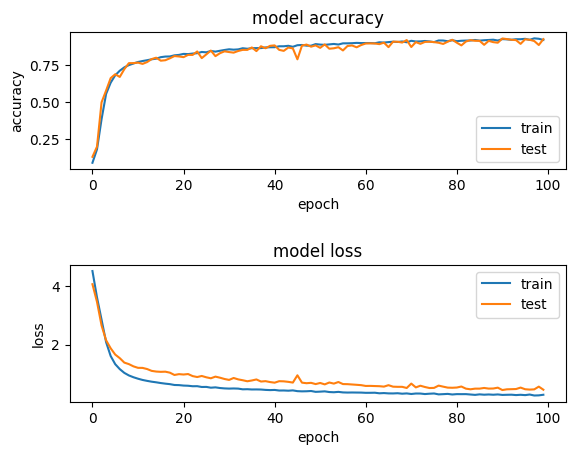

Final Test Accuracy: 0.9335888624191284


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os04g0475500         328              172       False
1  Os04g0659100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.492
1,2,0.798
2,3,0.867
3,4,0.893
4,5,0.898
5,6,0.908
6,7,0.900
7,8,0.916
8,9,0.934
9,10,0.924
